# Progetto Machine Learning: tecniche avanzate

il dataset utilizzato per le facce è "Human Faces" (https://www.kaggle.com/datasets/ashwingupta3012/human-faces)

Il dataset con immagini senza facce è "landscape-pictures" (https://www.kaggle.com/datasets/arnaud58/landscape-pictures)

In [ ]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import os
import json
import pathlib
import numpy as np
import matplotlib.pylab as plt
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn import svm
import random
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from google.colab.patches import cv2_imshow
import cv2
from skimage.transform import pyramid_gaussian
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
import imutils
from sklearn.svm import SVC
from PIL import Image
import os
import cv2
import numpy as np


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#Creazione dataset

In [ ]:
_ = files.upload() #kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
with open('kaggle.json') as f:
  kaggle_cred = json.load(f)

os.environ["KAGGLE_USERNAME"] = kaggle_cred["username"]
os.environ["KAGGLE_KEY"] = kaggle_cred["key"]

In [ ]:
!kaggle datasets download -d ashwingupta3012/human-faces #scarico dataset human faces

100% 1.82G/1.82G [00:20<00:00, 109MB/s]
100% 1.82G/1.82G [00:20<00:00, 94.8MB/s]


In [ ]:
!mkdir dataset
!unzip human-faces.zip -d dataset/ #creo la directory dataset che conterrà il dataset unzippato

Output streaming troncato alle ultime 5000 righe.
  inflating: dataset/Humans/1 (2910).jpg  
  inflating: dataset/Humans/1 (2911).jpg  
  inflating: dataset/Humans/1 (2912).jpg  
  inflating: dataset/Humans/1 (2913).jpg  
  inflating: dataset/Humans/1 (2914).jpg  
  inflating: dataset/Humans/1 (2915).jpg  
  inflating: dataset/Humans/1 (2916).jpg  
  inflating: dataset/Humans/1 (2917).jpg  
  inflating: dataset/Humans/1 (2918).jpg  
  inflating: dataset/Humans/1 (2919).jpg  
  inflating: dataset/Humans/1 (292).jpg  
  inflating: dataset/Humans/1 (2920).jpg  
  inflating: dataset/Humans/1 (2921).jpg  
  inflating: dataset/Humans/1 (2922).jpg  
  inflating: dataset/Humans/1 (2923).jpg  
  inflating: dataset/Humans/1 (2924).jpg  
  inflating: dataset/Humans/1 (2925).jpg  
  inflating: dataset/Humans/1 (2926).jpg  
  inflating: dataset/Humans/1 (2927).jpg  
  inflating: dataset/Humans/1 (2928).jpg  
  inflating: dataset/Humans/1 (2929).jpg  
  inflating: dataset/Humans/1 (293).jpg  
  infl

In [ ]:
#in che formato sono le immagini? e in che quantità?

folder = "./dataset/Humans"
#tutti i file nella cartella
files = os.listdir(folder)

#dizionario per tenere traccia dei formati
formati = {}

for file in files:
    estensione = os.path.splitext(file)[1]

    # conteggio
    if estensione in formati:
        formati[estensione] += 1
    else:
        formati[estensione] = 1

# stampo formati e relativi conteggi
for formato, conteggio in formati.items():
    print(f'Formato: {formato}, Conteggio: {conteggio}')

print("totale files: ", len(files))

Formato: .jpg, Conteggio: 6973
Formato: .jpeg, Conteggio: 78
Formato: .png, Conteggio: 150
Formato: .JPG, Conteggio: 18
totale files:  7219


In [ ]:
# Mantengo solo i files.jpg

for file in files:
    if not file.endswith('.jpg'):
        os.remove(os.path.join(folder, file))

# lista aggiornata dei file

files = os.listdir(folder)
print("totale files: ", len(files))

totale files:  6973


In [ ]:
# dataset con immagini senza facce
!kaggle datasets download -d arnaud58/landscape-pictures

 98% 607M/620M [00:06<00:00, 82.1MB/s]
100% 620M/620M [00:06<00:00, 98.5MB/s]


In [ ]:
!unzip landscape-pictures.zip -d dataset/landscape

Archive:  landscape-pictures.zip
  inflating: dataset/landscape/00000000.jpg  
  inflating: dataset/landscape/00000000_(2).jpg  
  inflating: dataset/landscape/00000000_(3).jpg  
  inflating: dataset/landscape/00000000_(4).jpg  
  inflating: dataset/landscape/00000000_(5).jpg  
  inflating: dataset/landscape/00000000_(6).jpg  
  inflating: dataset/landscape/00000000_(7).jpg  
  inflating: dataset/landscape/00000001.jpg  
  inflating: dataset/landscape/00000001_(2).jpg  
  inflating: dataset/landscape/00000001_(3).jpg  
  inflating: dataset/landscape/00000001_(4).jpg  
  inflating: dataset/landscape/00000001_(5).jpg  
  inflating: dataset/landscape/00000001_(6).jpg  
  inflating: dataset/landscape/00000001_(7).jpg  
  inflating: dataset/landscape/00000002.jpg  
  inflating: dataset/landscape/00000002_(2).jpg  
  inflating: dataset/landscape/00000002_(3).jpg  
  inflating: dataset/landscape/00000002_(4).jpg  
  inflating: dataset/landscape/00000002_(5).jpg  
  inflating: dataset/landscap

In [ ]:
#quanti file nella cartella "landscape"
num_files = len([f for f in os.listdir('dataset/landscape') if os.path.isfile(os.path.join('dataset/landscape', f))])
print(f"Ci sono {num_files} file nella cartella 'landscape'.")

Ci sono 4319 file nella cartella 'landscape'.


In [ ]:
#funzione che copia 4000 immagini random da una cartella e crea una lista
def copy_images(folder, label):
    all_images = os.listdir(folder)
    random.shuffle(all_images)

    for filename in all_images[:4000]:
        if filename.endswith(".jpg"):
            # Costruisci il percorso completo del file
            file_path = os.path.join(folder, filename)

            # Carica l'immagine
            img = Image.open(file_path)

            # Ridimensiona l'immagine a 128x128
            img = img.resize((128, 128))

            # Converti l'oggetto Image in un array NumPy
            img = np.array(img)

            # Aggiungi l'immagine alla lista
            images.append(img)
            labels.append(label)


In [ ]:
images = []
labels = []

In [ ]:
copy_images("dataset/Humans", 1)
copy_images("dataset/landscape", 0)

In [ ]:
len(images)

8000

In [ ]:
# Mescolo le immagini e le etichette nello stesso ordine
images, labels = shuffle(images, labels)

Etichetta: 0


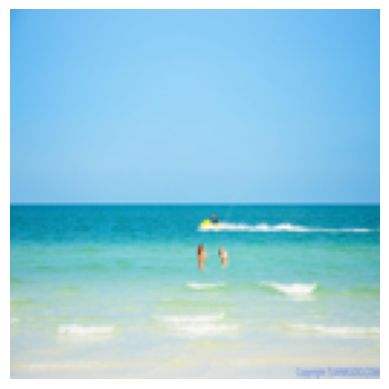

In [ ]:
index = random.randint(0, len(images)-1)

#immagine random
plt.imshow(images[index])
plt.axis('off')
#etichetta corrispondente 0:paesaggio, 1:faccia
print("Etichetta:", labels[index]);

# Preprocessing delle immagini

In [ ]:
#funzione che trasforma immagini in array, converte in scala di grigi se non lo sono già, estrae le hog features
def preprocess_images(images, pixels_per_cell=(16, 16), cells_per_block=(3, 3)):
    # Creare una lista vuota per le features
    X = []

    # Per ogni immagine nella lista, controllare il numero di canali ed estrarre le features di HOG
    for image in images:

        # Usa il metodo astype sull'array di NumPy e normalizzo
        image = np.array(image.astype(np.float32)) / 255.0

        # Se l'immagine è a colori, convertire l'immagine in scala di grigi
        if len(image.shape) == 3:
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Altrimenti, usare direttamente l'immagine in scala di grigi
        else:
            gray_image = image

        # Estrarre le features di HOG dall'immagine
        features = hog(gray_image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, orientations=9, visualize=False, multichannel=False)

        # Aggiungere le features alla lista
        X.append(features)

    # Convertire la lista in un array numpy
    X = np.array(X)

    # Ridimensionare X per adattarlo all'input del modello
    X = X.reshape(len(X), -1)

    return X



In [ ]:
# Divido il dataset in training e test set
images_train, images_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=1)

# preprocessing separato sui dataset di addestramento e di test
X_train = preprocess_images(images_train)
X_test = preprocess_images(images_test)


# Classificatore di facce SVM

si potrebbe usare random halving search per ottimizzare i parametri ma è molto lungo e il risultato non è molto diverso

In [ ]:
"""
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
svc = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}
halving_cv = HalvingGridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    factor=3,  # Fattore di riduzione per ogni iterazione
    cv=5,  # Numero di fold per la cross-validation
    scoring='accuracy',  # Scegli la metrica di valutazione desiderata
    n_jobs=-1  # Utilizza tutti i core disponibili
)
"""

"\nfrom sklearn.experimental import enable_halving_search_cv\nfrom sklearn.model_selection import HalvingGridSearchCV\nsvc = SVC(probability=True)\nparam_grid = {\n    'C': [0.1, 1, 10],\n    'kernel': ['linear', 'rbf'],\n    'gamma': [0.1, 1, 10]\n}\nhalving_cv = HalvingGridSearchCV(\n    estimator=svc,\n    param_grid=param_grid,\n    factor=3,  # Fattore di riduzione per ogni iterazione\n    cv=5,  # Numero di fold per la cross-validation\n    scoring='accuracy',  # Scegli la metrica di valutazione desiderata\n    n_jobs=-1  # Utilizza tutti i core disponibili\n)\n"

In [ ]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)

SVC(probability=True)

In [ ]:
svc.score(X_test, y_test)

0.98625

In [ ]:
# previsioni sul set di test
y_pred = svc.predict(X_test)

# matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Stampa la matrice di confusione
print('Confusion Matrix SVC:')
print(cm)

Confusion Matrix SVC:
[[1175   20]
 [  13 1192]]


Correct label: no face
Predicted label: no face detected


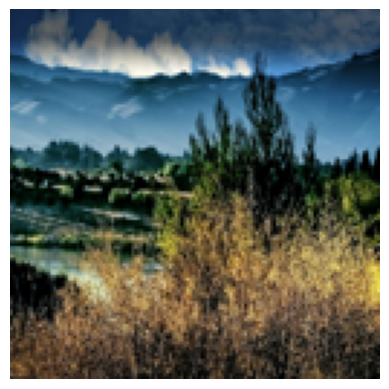

In [ ]:
#funzione che fa una predizione e mostra l'immagine corrispondente

def predict_and_display_random_image(model, X_test, y_test, images_test):
    # Scegli un'immagine a caso dal set di test
    index = np.random.randint(len(X_test))
    random_image = X_test[index]
    random_label = y_test[index]

    # Usa il modello per fare una previsione
    predicted_label = model.predict([random_image])

    # Stampa il label corretto e il label predetto
    print(f'Correct label: {"face" if random_label == 1 else "no face"}')
    print(f'Predicted label: {"face detected!" if predicted_label[0] == 1 else "no face detected"}')

    # Mostra l'immagine originale
    plt.imshow(images_test[index])
    plt.axis('off')
    plt.show()

# Utilizzo della funzione con immagini a caso del test set
predict_and_display_random_image(svc, X_test, y_test, images_test)

# Bounding box che contorna un volto

In [ ]:
#preprocessing di un'immagine

def preprocess_single_image(image):

    # Ridimensionare l'immagine a 128x128
    image = cv2.resize(image, (128, 128))

    # Usa il metodo astype sull'array di NumPy e normalizzo
    image = np.array(image.astype(np.float32)) / 255.0

    # Se l'immagine è a colori, convertire l'immagine in scala di grigi
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Altrimenti, usare direttamente l'immagine in scala di grigi
    else:
        gray_image = image

    # Estrarre le features di HOG dall'immagine
    features = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(3, 3), orientations=9, visualize=False, multichannel=False)

    # Convertire le features in un array numpy e ridimensionarlo per adattarlo all'input del modello
    X = np.array(features).reshape(1, -1)

    return X


In [ ]:
#funzione che crea una finestra scorrevole sull'immagine

def sliding_window(image, stepSize, windowSize):
    # scorri la finestra attraverso l'immagine
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # ritorna la porzione corrente della finestra
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
#funzione che genera una piramide di immagini ridimensionate a diverse scale

def pyramid(image, scale=1.5, minSize=(30, 30)):

    #restituisce imagine originale
    yield image


    while True:
        # Calcola le nuove dimensioni dell'immagine e ridimensionala
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

       # Se l'immagine ridotta non soddisfa la dimensione minima fornita,
       # interrompi la costruzione della piramide
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # restituisce la prossima immagine nella piramide
        yield image


In [ ]:
# funzione che rileva i volti nell'immagine, usando sliding_window, pyramid e SVC

def detect_face(image, svc):
    # dimensioni della finestra
    winW, winH = 96, 96

    # inizializza la previsione massima e il rettangolo corrispondente
    max_prediction = -1
    max_rectangle = None

    # soglia di confidenza
    threshold = 0.5

    # loop sulla piramide di immagini
    for resized in pyramid(image, scale=1.5):
        # loop sulla sliding window per ogni porzione dell'immagine ridimensionata
        for (x, y, window) in sliding_window(resized, stepSize=12, windowSize=(winW, winH)):
            # se la finestra non incontra le nostre dimensioni di finestra desiderate, ignora
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            # ESTRATTORE DI FEATURES
            features = preprocess_single_image(window)

            # PREDIZIONE
            prediction = svc.predict_proba(features)[0][1]

            # se la previsione è maggiore della previsione massima corrente e supera la soglia, aggiorna la previsione massima e il rettangolo corrispondente
            if prediction > max_prediction and prediction > threshold:
                max_prediction = prediction
                max_rectangle = (x, y, x + winW, y + winH)

    # se abbiamo trovato un rettangolo, disegnalo sull'immagine
    if max_rectangle is not None:
        cv2.rectangle(image, (max_rectangle[0], max_rectangle[1]), (max_rectangle[2], max_rectangle[3]), (0, 255, 0), 2)
    # mostra l'immagine di output
    plt.imshow(image)
    plt.axis("off")
    plt.show();

    # stampa le coordinate del rettangolo
    if max_rectangle is not None:
        print("FACE DETECTED!")
    else:
        print("No face detected.")

    # ritorna le coordinate del rettangolo come una lista
    return list(max_rectangle) if max_rectangle else []


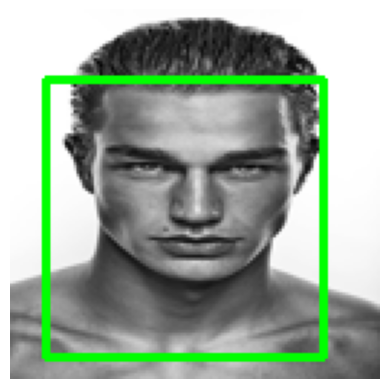

FACE DETECTED!


[12, 24, 108, 120]

In [ ]:
# Seleziona un indice casuale dal test set
random_index = np.random.choice(len(images_test))

# Usa l'indice per selezionare un'immagine
random_image = images_test[random_index]

# Applica la funzione di rilevamento delle facce all'immagine
detect_face(random_image, svc)

# Immagini fuori dal test set

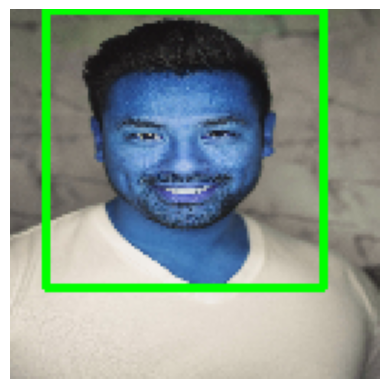

FACE DETECTED!


[12, 0, 108, 96]

In [ ]:
# Leggi l'immagine con OpenCV
image = cv2.imread("face.jpg")
image = cv2.resize(image,(128,128))
detect_face(image, svc)

# Limite:
per come è composto detect_face rileverà sempre e solo una faccia, sarebbe opportuno modificare la funzione permettendole di rilevare più volti e con una non maximum suppression eliminare i rettangoli ridondanti, ma per come è fatto il mio dataset di train questo peggiorerebbe solamente le performance oppure comporterebbe comunque la rilevazione di un solo volto, e deve essere in primo piano, se no non viene rilevato affatto

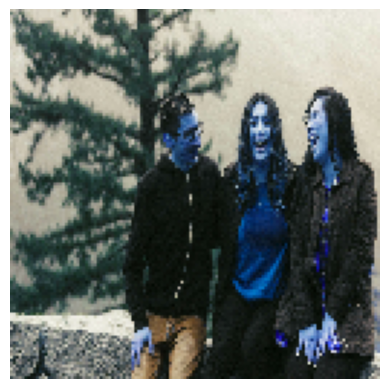

No face detected.


[]

In [ ]:
# Leggi l'immagine con OpenCV
image = cv2.imread("3_people.jpg")
image = cv2.resize(image,(128,128))
detect_face(image, svc)

In [ ]:
from sklearn.preprocessing import binarize

def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

def detect_faces(image, svc):
    # dimensioni della finestra
    winW, winH = 96, 96

    # soglia di confidenza
    threshold = 0.5

    # inizializza una lista per le previsioni e i rettangoli
    predictions = []
    rectangles = []

    # loop sulla piramide di immagini
    for resized in pyramid(image, scale=1.5):
        # loop sulla sliding window per ogni porzione dell'immagine ridimensionata
        for (x, y, window) in sliding_window(resized, stepSize=12, windowSize=(winW, winH)):
            # se la finestra non incontra le nostre dimensioni di finestra desiderate, ignora
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            # ESTRATTORE DI FEATURES
            features = preprocess_single_image(window)

            # PREDIZIONE
            prediction = svc.predict_proba(features)[0][1]

            # se la previsione supera la soglia, aggiungi alla lista delle previsioni e dei rettangoli
            if prediction > threshold:
                predictions.append(prediction)
                rectangles.append((x, y, x + winW, y + winH))

    # applica la non-maximum suppression ai rettangoli
    rectangles = np.array(rectangles)
    rectangles = non_max_suppression(rectangles, overlapThresh=0.3)

    # disegna i rettangoli sull'immagine
    for (x1, y1, x2, y2) in rectangles:
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # mostra l'immagine di output
    plt.imshow(image)
    plt.axis("off")
    plt.show();

    # stampa il numero di volti rilevati
    print(f"{len(rectangles)} faces detected.")

    # ritorna i rettangoli come una lista di liste
    return rectangles.tolist()


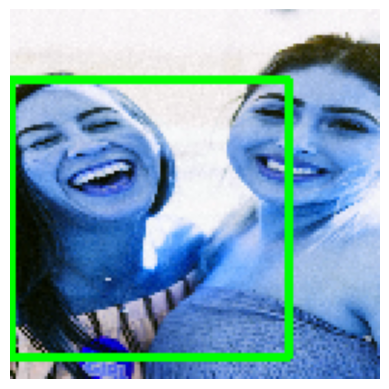

1 faces detected.


[[0, 24, 96, 120]]

In [ ]:
image = cv2.imread("2_girls.jpg")
image = cv2.resize(image,(128,128))
detect_faces(image, svc)

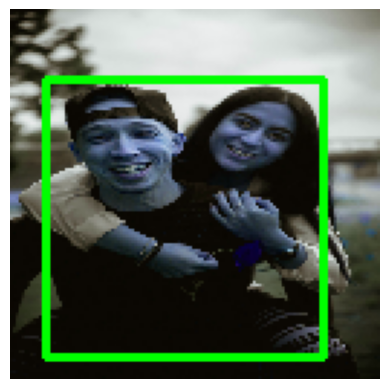

1 faces detected.


[[12, 24, 108, 120]]

In [ ]:
image = cv2.imread("2_people.jpg")
image = cv2.resize(image,(128,128))
detect_faces(image, svc)